# **ResNet-18 model -based detection and analysis of COVID-19 on chest X-ray images using PyTorch**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-model-summary

# Importing Libraries

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import shutil
import random
import torch
import torchvision
from pytorch_model_summary import summary
import numpy as np
import time
import warnings
from PIL import Image
from matplotlib import pyplot as plt
torch.manual_seed(0)
print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.11.0+cu113


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('Default GPU Device: {}'.format(torch.cuda.get_device_name(0)))
else:
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')

Default GPU Device: Tesla K80


# Preparing Training and Test Sets

In [5]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [6]:
# Create dictionary self.images{} with the 3 classes and the list  of image names in each class
class ChestXRayDataset(torch.utils.data.Dataset):
    
    def __init__(self, image_dirs, transform):
        
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')   # using f-string formatting
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])   # rest of the division by class length to avoid out-of-bound index
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')  # for pretrained network accepting RGB images
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [7]:
train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.Resize(size=(224, 224)),
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
                 torchvision.transforms.Resize(size=(224, 224)),
                 torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [8]:
train_dirs = {
    'normal': '/content/drive/MyDrive/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/MyDrive/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/MyDrive/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 11503 normal examples
Found 1315 viral examples
Found 3805 covid examples


In [9]:
test_dirs = {
    'normal': '/content/drive/MyDrive/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/MyDrive/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/MyDrive/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [10]:
batch_size = 6
dloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dloader_train))
print('Number of test batches', len(dloader_test))

Number of training batches 2771
Number of test batches 15


# Data Visualization

In [11]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 8))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        #The mean and std of ImageNet are: mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
        #Normalize the image by setting its mean and standard deviation to the specified values.
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.rc('axes', labelsize=14)
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

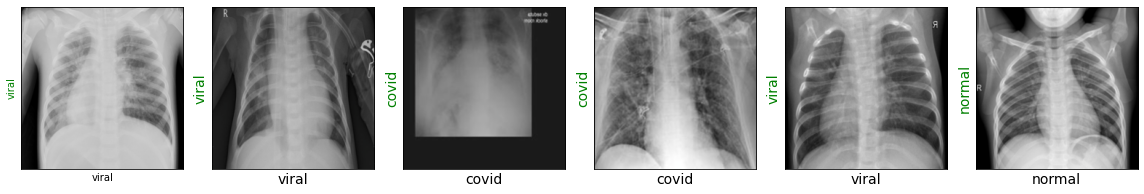

In [12]:
images, labels = next(iter(dloader_train))
show_images(images, labels, labels)

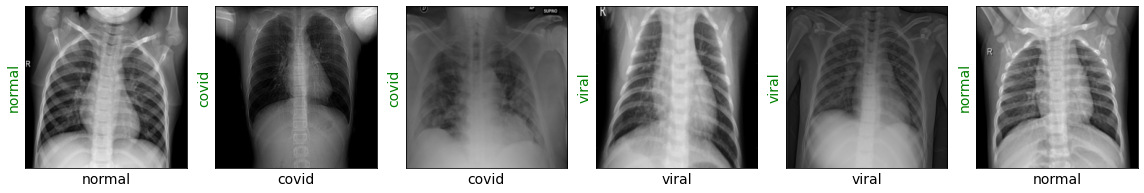

In [13]:
images, labels = next(iter(dloader_test))
show_images(images, labels, labels)

# Creating the Model

In [14]:
model = torchvision.models.resnet18(pretrained=True)
print(summary(model, torch.zeros((1, 3, 224, 224)), 
              show_input=False, 
              show_hierarchical=False, 
              print_summary=False))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 64, 112, 112]           9,408           9,408
          BatchNorm2d-2     [1, 64, 112, 112]             128             128
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4       [1, 64, 56, 56]               0               0
           BasicBlock-5       [1, 64, 56, 56]          73,984          73,984
           BasicBlock-6       [1, 64, 56, 56]          73,984          73,984
           BasicBlock-7      [1, 128, 28, 28]         230,144         230,144
           BasicBlock-8      [1, 128, 28, 28]         295,424         295,424
           BasicBlock-9      [1, 256, 14, 14]         919,040         919,040
          BasicBlock-10      [1, 256, 14, 14]       1,180,672       1,180,672
          BasicBlock-11        [1, 512, 7, 7]       3,673,088  

In [15]:
# Adjust classification layer to problem at hand with 3 output classes
model.fc = torch.nn.Linear(in_features=512, out_features=3)
##in_features – size of each input sample
#out_features – size of each output sample
model.to(device)

# Define loss function and Optimizer. Select all model parameters to be fined-tuned
criterion = torch.nn.CrossEntropyLoss()#criterion computes the cross entropy loss between input and target.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5) #0.00003

In [16]:
def show_preds():
    model.eval()
    images, labels = next(iter(dloader_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

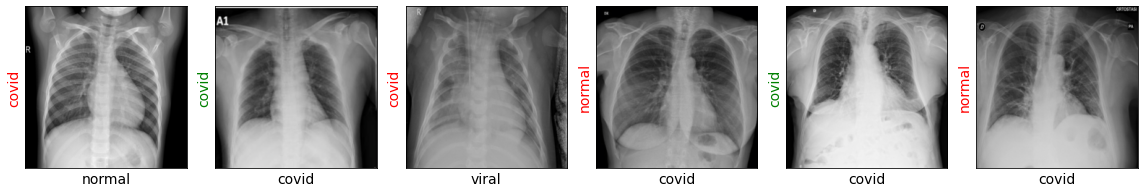

calculating model accuracy before training (should be 1/3 for 3 classes)....
Accuracy of un-trained model: 0.2444


In [18]:
show_preds()
print('calculating model accuracy before training (should be 1/3 for 3 classes)....')
accuracy = 0
# Evaluate accuracy of non-trained model
model.eval()      
for val_step, (images, labels) in enumerate(dloader_test):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    accuracy += sum((preds == labels).cpu().numpy())          
accuracy = accuracy / len(test_dataset)
print(f'Accuracy of un-trained model: {accuracy:.4f}')

# Training the Model

In [19]:
def train(epochs):
    
    print('Start training..')
    
    start_time = time.time()
    running_train_loss = []
    running_val_loss = []
    k=0
    
    for epoch in range(epochs):
        
        print('='*20)
        print(f'Starting epoch {epoch + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dloader_train):
            
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                k=k+1
                accuracy = 0
                model.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dloader_test):
                    
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                current_time = time.time()
                
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f} Training time: {(current_time-start_time)//60:.0f} minutes')

                show_preds()
                
                running_val_loss.append(val_loss)

                model.train()

                if accuracy >= 0.75:
                    print('Performance condition satisfied, stopping..\nNumbers of epochs = ',k)
                    print(f'Training Loss: {train_loss:.4f}')
                    #print('Training complete..')
                    save_file = '/content/drive/MyDrive/COVID-19 Radiography Database/rozaAhmedKemal-resnet18.pth'
                    torch.save(model.state_dict(), save_file)
                    return running_train_loss, running_val_loss

            train_loss /= (train_step + 1)
            running_train_loss.append(train_loss)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Start training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.2030, Accuracy: 0.2333 Training time: 0 minutes


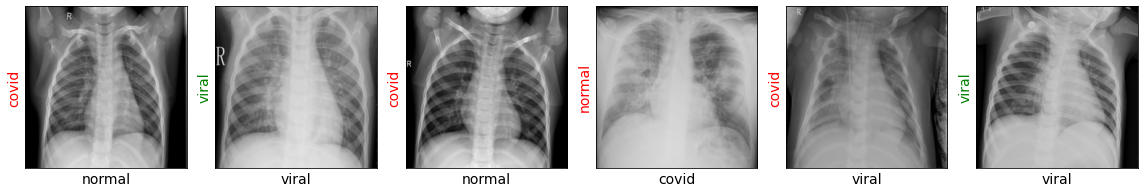

Evaluating at step 20
Validation Loss: 0.8698, Accuracy: 0.7000 Training time: 2 minutes


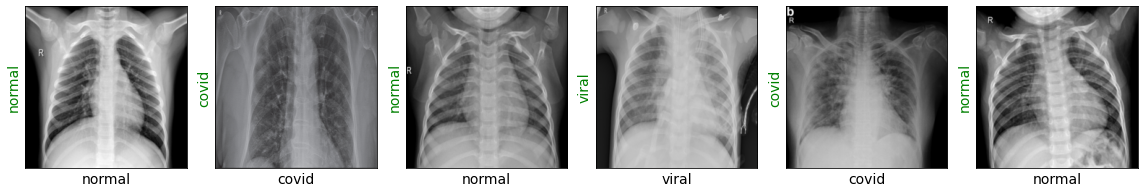

Evaluating at step 40
Validation Loss: 0.5409, Accuracy: 0.8889 Training time: 3 minutes


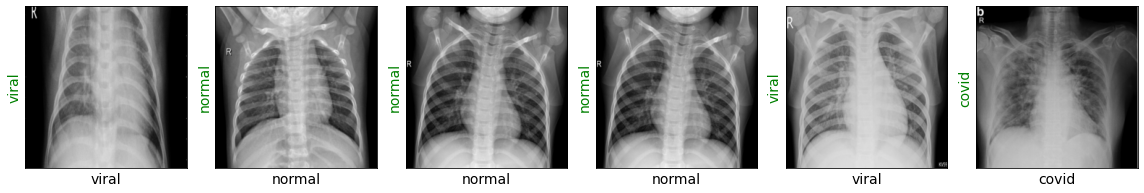

Performance condition satisfied, stopping..
Numbers of epochs =  3
Training Loss: 0.7628
CPU times: user 20.4 s, sys: 869 ms, total: 21.2 s
Wall time: 3min 23s


In [20]:
%%time
running_train_loss, running_val_loss = train(epochs=1)

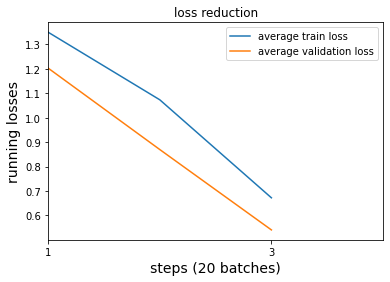

In [21]:
# Plot Loss reduction profile
steps = len(running_val_loss)
plt.plot(np.arange(1, steps+1,1),running_train_loss[:steps], label='average train loss')
plt.plot(np.arange(1,steps+1,1), running_val_loss[:steps], label='average validation loss')
plt.xticks(range(1,steps+1,2))
plt.xlim(1,steps+1)
plt.xlabel('steps (20 batches)')
plt.ylabel('running losses')
plt.title('loss reduction')
plt.legend(loc='upper right')
filename = 'loss_profile.png'
plt.savefig(filename)
plt.show()

# Final Results

In [ ]:
# load the saved model
save_file = '/content/drive/MyDrive/COVID-19 Radiography Database/rozaAhmedKemal-resnet18.pth'
if torch.cuda.is_available():
    model.load_state_dict(torch.load(save_file))
else:
    model.load_state_dict(torch.load(save_file, map_location=torch.device('cpu')))

In [ ]:
show_preds()

In [ ]:
# Calculate accuracy by class
print('calculating model accuracy after training....')
num_classes = len(class_names)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
    
model.eval()      
for val_step, (images, labels) in enumerate(dloader_test):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    
    correct_tensor = preds.eq(labels.view_as(preds))    # equivalent to tensor.view(preds.size())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
for i in range(num_classes):
    if class_total[i] > 0:
            
        print('Test Accuracy on {}:'.format(class_names[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(10,' '), 
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))
            
    else:
        print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))
                      
print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(25),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(5))

    
    

In [ ]:
#printMetrics(results)

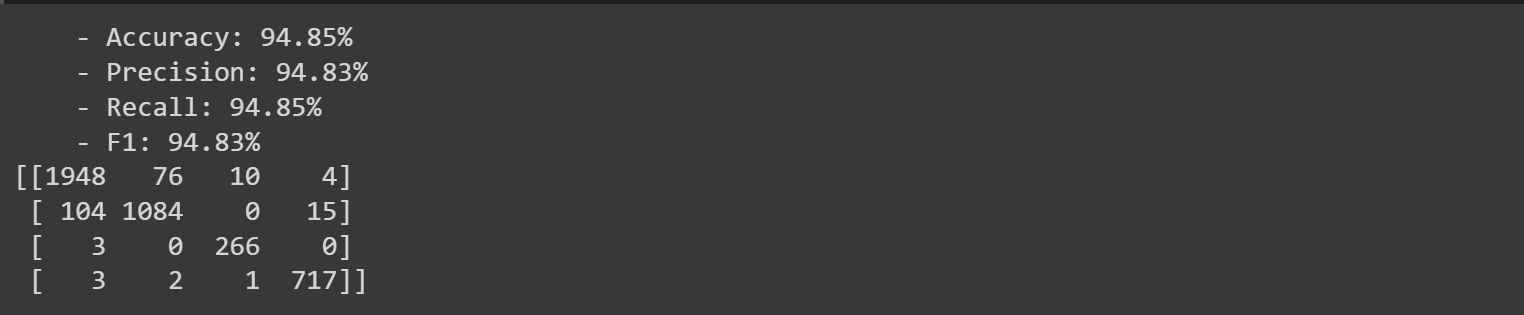